In [1]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
import numpy as np
import os
import nltk
import re
import pickle
from time import time
from gensim import corpora, models, similarities
from itertools import chain
from _datetime import datetime
from lxml import etree
import json
from nltk.corpus import stopwords as sp
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from math import log
from pprint import pprint as pp
from string import punctuation
from collections import defaultdict, deque, OrderedDict
import pandas as pd
import numpy
import logging

**Парсинг дат**

In [4]:
from datetime import datetime

def parse_date(date_string, product_list=False):
    # '2009-01-01 08:25:07'
    # 2012-01-17T17:57:00-05:00
    # Friday November 10, 2006 10:49 pm PST
    # November 2, 2012 - product list
    if not product_list:
        if 'T' not in date_string:
            date = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S').date()
        elif 'pst' in date_string.lower() or 'pdt' in date_string.lower():
            date = datetime.strptime(date_string[:-4], '%A %B %d, %Y %H:%M %p').date()
        else:
            date = datetime.strptime(date_string[:-6], '%Y-%m-%dT%H:%M:%S').date() 
    else:
        date = datetime.strptime(date_string, '%B %d, %Y').date()
    return date

def parse_dates(dates):
    return [parse_date(date) for date in dates]

**Препроцессинг**

In [153]:
def read_data(filename):
    data = pd.read_excel(filename)
    return data

with open('..\english_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [word.strip('\n') for word in f.readlines()]
# stopwords = list(set(sp.words('english') + stopwords))
# lemmatizer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
numbers = re.compile('[0-9]')
punctuation += '\n—–- «»\'\"'
lemmatization_stoplist = ['3gs', '4s', '5s', '6s']
product_lemm_reg = re.compile("(iphone|ipad|ipod|macbook|[ie]mac|air|5c|classic|nano|tv|ibook|shuffle|touch|mini|pro|powerbook)(s|es)")

def lemmatize(text, allow_stopwords=False):
    if allow_stopwords:
        current_stopwords = []
    else:
        current_stopwords = stopwords[:]
    lemmatized = [lemmatizer.lemmatize(word).lower() 
                  if not word in lemmatization_stoplist else word.lower() 
                  for word in nltk.word_tokenize(text) 
                    if word.lower() not in current_stopwords + list(punctuation) and (numbers.search(word) is None or word in lemmatization_stoplist)
                    and word not in ["''", ' ', '``', '', "'s"]
                 ]
    product_lemmatized = [product_lemm_reg.sub('\\1', word) for word in lemmatized]
    return product_lemmatized

def preprocess_text(text, split=None, allow_stopwords=False):
    if split == 'sentence':
        sentences = nltk.sent_tokenize(text)
        return [lemmatize(sent, allow_stopwords) for sent in sentences]
    elif split == 'paragraph_sentence':
        try:
            paragraphs = [nltk.sent_tokenize(par) for par in re.split('[\r\n]{2,}', text) if not par.strip() == '']
        except:
            print(text)
        return [[lemmatize(sent, allow_stopwords) for sent in sents if not sent.strip() == ''] for sents in paragraphs]
    elif split == 'paragraph':
        paragraphs = [lemmatize(par, allow_stopwords) for par in re.split('[\r\n]{2,}', text)]
        return paragraphs
    else:
        return lemmatize(text)

def pickle_serialize(obj, filename):
    with open(filename, 'wb') as f:
        f.write(pickle.dumps(obj))    
    
def make_corpus(filename, serialize=None):
    data = read_data(filename)
    dates = parse_dates(data['datetime'])
    preprocessed_docs =  [[id, date, preprocess_text(body, split='paragraph_sentence')] for (id, body), date in zip(enumerate(list(data['body'])), dates) if not pd.isnull(body) and not body.strip() == '']
    if serialize:
        pickle_serialize(preprocessed_docs, serialize)
    return preprocessed_docs

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.loads(f.read())

Загрузим и предобработаем все корпуса. 
Затем склеим их в один большой корпус, чтобы построить по нему тематическую модель.

In [424]:
combined_corpus = defaultdict(list)
[combined_corpus[date].append(pars) for id, date, pars in load_pickle('../DATA/AppleInsiderLemmatized.pickle')]
[combined_corpus[date].append(pars) for id, date, pars in load_pickle('../DATA/MacRummorsLemmatized.pickle')]
[combined_corpus[date].append(pars) for id, date, pars in load_pickle('../DATA/NineToFiveMacLemmatized.pickle')]
id, cc, all_docs, cc_corpus, cc_sent_par_corpus = 0, [], [], [], []
for date, docs in sorted(combined_corpus.items(), key=lambda x: x[0]):
    for pars in docs:
        cc_sent_par_corpus.append([id, date, pars])
        cur_doc, cur_corp = [], []
        for par in pars:
            flat_par = list(chain(*par))
            cc.append(flat_par)
            cur_doc.extend(flat_par)
            cur_corp.append(flat_par)
        all_docs.append(cur_doc)
        cc_corpus.append([id, date, cur_corp])
        id += 1

**Подготавливаем данные для построения тематической модели**

In [9]:
from itertools import chain

def make_batches(corpus ,test=False):
    if test:
        first_batch_len = 100
    else:
        first_batch_len = 2000
    batch_id = 0
    batches = []
    prev_date = corpus[0][1]
    current_batch = []
    for id, date, paragraphs in corpus:
        if batch_id != 0:
            current_batch.extend([list(chain(*sents)) for sents in paragraphs])
            if len(current_batch) >= 30:
                batches.append([date, current_batch])
                current_batch = []
        else:
            if len(current_batch) < first_batch_len:
                current_batch.extend([list(chain(*sents)) for sents in paragraphs])
            else:
                prev_date = date
                batch_id += 1
    return batches

def make_dictionary(texts, test=False):
    dictionary = corpora.Dictionary(texts)
    if test:
        dictionary.filter_extremes(no_below=1, no_above=1000, keep_n=None)
    else:
        dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=None)
    print(dictionary)
    return  dictionary

def make_bow_texts(batch, dictionary):
    bow_texts = [dictionary.doc2bow(text) for text in batch]
    return bow_texts

In [10]:
cc_dict = make_dictionary(all_docs)
cc_bows = make_bow_texts(cc, cc_dict)

Dictionary(15219 unique tokens: ['dependence', 'bracket', 'inspired', 'spun', 'debuted']...)


**Считаем распределение топиков во времени**

In [83]:
def load_topic_models(directory):
    from datetime import datetime
    models_dict = {}
    for filename in os.listdir(directory):
        if '.' not in filename:
            date = datetime.strptime(filename, '%Y-%m-%d').date()
            models_dict[date] = os.path.join(directory, filename)
    return models_dict

# models_dict = load_topic_models('test_model')
# models_dict

In [262]:
def load_model(filename):
    return models.LdaMulticore.load(filename)

#     return [([id2word[id] for id in model.get_topic_terms(topic)], prob) for topic, prob in topics]
    
def get_topic_distributions(dictionary, data, model_dict):
    import datetime
    print('start gathering')
    models_dates = list(model_dict.keys())
    topic_by_date_counts = defaultdict(lambda: defaultdict(int))
    date_by_topic_counts = defaultdict(lambda: defaultdict(int))
    current_model_date = min(models_dates)
    model = load_model(model_dict[current_model_date])
    print('model loaded')
    for id, date, paragraphs in data:
        if date <= max(models_dates) and date <= datetime.date(2009, 1, 27):
            cur_topics = defaultdict(int)
            min_model_date = min([d for d in models_dates if d >= date])
            if current_model_date < min_model_date:
                model = load_model(model_dict[min_model_date])
                current_model_date = min_model_date
                print(current_model_date)
            par_bows = [dictionary.doc2bow(list(chain(*par))) for par in paragraphs]
            for bow in par_bows:
                topics = model.get_document_topics(bow, minimum_probability=0.5)
                for topic, prob in sorted(topics, key=lambda  x: -x[1])[:5]:
                    topic_terms = '+'.join([w for w, p in model.show_topic(topic, 5)])
                    cur_topics[topic_terms] += 1  # ID топиков со временем меняются, поэтому используем слова в к-ве id
            if cur_topics:
                doc_topics = sorted(cur_topics.items(), key=lambda x: -x[1])[:5]
                print(doc_topics)
                for topic, prob in doc_topics:
                    topic_by_date_counts[date][topic] += 1
                    date_by_topic_counts[topic][date] += 1
            
    return topic_by_date_counts, date_by_topic_counts
        
# tbd, dbt = get_topic_distributions(test_dict, test_corpus,  models_dict)
# dbt

def get_topics(tokenized_text, date, model_dict, id2word, threshold=0.1):
    models_dates = list(model_dict.keys())
    min_model_date = min([d for d in models_dates if d >= date])
#     print(min_model_date)
    model = load_model(model_dict[min_model_date])
#     print(model)
    bow = id2word.doc2bow(tokenized_text)
    topics = model.get_document_topics(bow, minimum_probability=threshold)
    model.id2word = id2word
    return [('+'.join([w for w, p in model.show_topic(topic)]), prob) for topic, prob in topics]    
    
text = """
"Fortune summarizes a pair of analyst reports out today suggesting that Apple may be experiencing some supply constraints on the iPhone 4S during this holiday quarter.  The company has obviously been working hard to demand for the device as shipping estimates through iPhone carrier partners and even Apple itself have at times been lengthy, but beyond high demand the new reports suggest that Apple may be having some trouble meeting its own production goals for the device.
 the reason behind his reduction in quarterly iPhone sales of about three million units, moving from 26-28 million units to 23-25 million units.  He notes that demand appears to remain strong but that Apple is having a hard time producing enough iPhones to meet that demand.Related Roundup: iPhone 6s Tags: Rodman and Renshaw, Ashok Kumar, Susquehanna, Jeff Fidacaro Buyer's Guide: iPhone (Neutral) "

"""
# get_topics(preprocess_text(text), datetime.date(2011, 11, 29), time_model_dict, time_model_id2word, 0.001)

**Визуализируем распределение**

In [ ]:
cc_models_dict = load_topic_models('paragraphs_unconverged_model3')
cc_tbd, cc_dbt = get_topic_distributions(cc_dict, cc_docs,  cc_models_dict)

In [ ]:
%matplotlib qt 
cc_dates = sorted(cc_tbd.keys())
plot_topics(cc_dbt, cc_dates)

**Считаем статистику по топикам в коллекции**

In [14]:
def count_topics(paragrsph_split_texts, model, dictionary, threshold, count_by='doc'):
    """
    Counts the number of times each topic from a given model occurred in each of the bow_texts with corresponding 
    dates from the dates array.
    """
    date_counts = defaultdict(lambda: defaultdict(int))
    overall_counts = defaultdict(int)
    for id, date, paragraphs in paragrsph_split_texts:
        if count_by == 'par':
            for paragraph in paragraphs:
                if type(paragraph) == list:
                    bow = dictionary.doc2bow(list(chain(*paragraph)))
                else:    
                    bow = dictionary.doc2bow(paragraph)
                if not len(paragraph) == 0:
                    topics = model.get_document_topics(bow, minimum_probability=threshold)
                    for topic, prob in topics:
                        date_counts[date][topic] += 1
                        overall_counts[topic] += 1
        elif count_by == 'doc':
            bow = dictionary.doc2bow(list(chain(*paragraphs)))
            topics = model.get_document_topics(bow, minimum_probability=threshold)
            for topic, prob in topics:
                date_counts[date][topic] += 1
                overall_counts[topic] += 1
    return date_counts, sorted(overall_counts.items(), key=lambda x: -x[1])

def topics_words(model, sprted_topic_counts, topics_number=20, words_number=10):
    terms = []
    for topic, count in sprted_topic_counts[:topics_number]:
        most_frequent_words = model.show_topic(topic, words_number)
        terms.append([topic, count, ', '.join([word for word, prob in most_frequent_words])])
    return terms

# all_date_counts, all_topic_counts = count_topics(log_progress(cc_corpus[50000:50100]), all_model, all_dict, 0.01, count_by='doc')

**Подготовим данные для построения "классификатора утечек"**

Для начала загрузим модель, построенную на всей коллекции с трех сайтов

In [32]:
mcr_model = models.LdaModel.load('./models/400_topics.model')
mcr_dict = corpora.Dictionary.load('./models/400_topics.model.id2word')
mcr_model.id2word = mcr_dict
all_bows = make_bow_texts(all_docs, mcr_dict)
cc_bows = make_bow_texts(cc, mcr_dict)

Посмотрим какие топики получились

In [ ]:
for id, words in mcr_model.show_topics(600, 20, formatted=False):
    print(id, [word for word, prob in words])

Сделаем функцию, которая отфильтровывает документы,  в которых встретилсь топики с заданными номерами и записывает их в файл

In [15]:
def find_topics(filename, model, doc_bow, docs, topic_id_list):
    filtered_docs = []
    topic_id_list = set(topic_id_list)
    wiritten = 0
    i = 0
    for bow in log_progress(doc_bow):
#         if i and i % 1000 == 0: 
#             print(i)
        cur_topics = model.get_document_topics(bow, minimum_probability=0.1)
        cur_topic_ids = set([id for id, prob in cur_topics])
        intersection = topic_id_list.intersection(cur_topic_ids)
        if intersection:
            best_topic = list(max([(id, prob) for id , prob in cur_topics if id in intersection], key=lambda x: -x[1]))
            filtered_docs.append([i, ' '.join(docs[i])] + best_topic) 
        i += 1
    pd.DataFrame(sorted(filtered_docs, key=lambda x: -x[-1])).to_excel(filename, index=False, header=['id', 'text', 'best_topic_id', 'probability'])

Найдем такие документы в macrummors. Просмотр топиков показал, что топики с таким смыслом это [334, 350, 148, 126, 52, 182, 216, 94, 170]

In [71]:
find_topics('mcr_leaks_data_full_docs.xlsx', mcr_model, all_bows, all_docs, [334, 350, 148, 126, 52, 182, 216, 94, 170])
keynotes and announcements topics: 216, 94, 170

Теперь надо собрать набор документов, не являющихся утечкамии

In [421]:
leak_data = pd.read_excel('mcr_leaks_data_full_docs.xlsx')
leak_data= leak_data.loc[leak_data['best_topic_id'].isin([334, 350, 126, 52])]
leak_data['class'] = 1

In [422]:
leak_data_filtered = leak_data.loc[(leak_data['probability']<0.6), ['text', 'class']]
leak_data_filtered.shape

(3860, 2)

In [425]:
leaks_ids = leak_data.id
# non_leak_data = pd.DataFrame([[' '.join(par), 0] for i, par in enumerate(cc) if not i in leaks_ids], columns=['text', 'class'])
non_leak_data = pd.DataFrame([[' '.join(par), 0] for i, par in enumerate(all_docs) if not i in leaks_ids], columns=['text', 'class'])
non_leak_data.shape

(54209, 2)

In [449]:
df = pd.concat([leak_data_filtered, non_leak_data.sample(frac=0.06)])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,class
0,apple could n't trademark app store got domain...,0
1,rumor out far east on thursday claim apple sup...,1
2,in february first image depicting back casing ...,1
3,big news iphone cravers in uk report morning c...,0
4,volkswagen’s vw line one notable holdout from ...,1


In [450]:
X = [t if not pd.isnull(t) else '' for t in list(df['text'])]
y = df['class']
# assert X.shape == y.shape
# X.shape, y.shape

**Построим классификтор утечек**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BaseNB, BernoulliNB
from sklearn.svm import SVC

In [451]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [461]:
clf = LogisticRegression(verbose=1,solver='liblinear')
y_pred = cross_val_predict(clf, X_tfidf, y, verbose=1, cv=4)
print(classification_report(y, y_pred))

[LibLinear][LibLinear][LibLinear][LibLinear]             precision    recall  f1-score   support

          0       0.86      0.85      0.85      3253
          1       0.87      0.88      0.88      3860

avg / total       0.87      0.87      0.87      7113



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s finished


In [462]:
leaks_classifier = LogisticRegression(solver='liblinear')
leaks_classifier.fit(X_tfidf, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [212]:
def is_leak(text, preprocess=False):
    if preprocess:
        text = preprocess_text(text)
    tf_idf_text = vectorizer.transform([' '.join(text)])
    return leaks_classifier.predict(tf_idf_text)[0]

**Теперь функции для поиска упоминаний продуктов в текстах**

In [347]:
import re
def make_product_tuple(product_full_name):
    name_cleaned = ''.join([char for char in product_full_name.lower() if not char in '()\'"&']).split()
    parts_to_remove = ['gb', '+', 'with', 'wcdma', 'cdma', 'gsm', '16', '32', '64', '128']
    name_cleaned = tuple([re.sub('([0-9])(rd|st|nd|th)', '\\1', word) for word in name_cleaned if not word in parts_to_remove])
    return name_cleaned

def make_product_regex(product_full_name, min_req):
    product_tuple = make_product_tuple(product_full_name)
    product_regex = ''
    for i in range(len(product_tuple)):
        if i < min_req:
            product_regex += '\ ({})'.format(product_tuple[i])
        else:
            product_regex += '(\ *{})?'.format(product_tuple[i])
    modifiers = """(?P<new_products>  # a group for the words reffering to new and upcoming products
            new(?:est)?|(?:up)?coming|to\ *?be\ *?ann?ounced|updated?|
            (next\ *?-?\ *?(?:gen(?:eration)?|year)?)
       )?
       (?P<launched_products> # a group for the words reffering to the old or already launched products
           (?: (current|last|previous)\ *?-?\ *?(?:gen(?:eration)?|year)?)
           |(?:this\ *?-?\ *?(?:gen(?:eration)?|year)?)
       )?\ *?"""
    product_regex = modifiers + product_regex.strip()
    return re.compile(product_regex.strip(), re.X)

def read_product_list(product_list_file):
    models = defaultdict(lambda: defaultdict(list))
    model2family = {}
    product_list = read_data(product_list_file)
    for i, (year, launched, date_launched, model_full, keywords, inter_req, model_group, family) in product_list.iterrows():
        product = make_product_regex(keywords, inter_req)
        date = parse_date(date_launched, True)
        model_group = ' '.join(model_group.split())
        model2family[model_group] = family
        if not product in models[date][model_group]:
            models[date][model_group].append((product, inter_req))
    return models, model2family

In [386]:
from datetime import datetime

def find_mention(tokenized_text, regex):
    text_string = ' '.join(tokenized_text)
    matches = regex.finditer(text_string)
    return matches

def delete_intersections(product_mentions):
    pm = sorted(product_mentions, key=lambda x: (x[2].start(), -x[2].end()))
    first_mention = pm[0]
    filtered = [first_mention]
    p_product, p_launch_date, (p_start, p_end) = first_mention[0], first_mention[1], first_mention[2].span()
    for mention in pm[1:]:
        product, launch_date, (start, end) = mention[0], mention[1], mention[2].span()
        last_added_span = tuple(filtered[-1][-1].span())
        if product != p_product and (end > p_end or start > p_end or (start, end) == last_added_span):
            filtered.append(mention)
    return filtered

def sort_by_date(product_mentions, article_date):
    launched_products =  []
    upcoming_products =  []
    for mention in product_mentions:
        product, launch_date, match = mention
        has_new_word = match.group('new_products')
        has_launched_word = match.group('launched_products')
        if launch_date >= article_date:
            if not has_launched_word and has_new_word:
                upcoming_products.append(mention)
        elif launch_date < article_date:
            if not has_new_word and has_launched_word:
                launched_products.append(mention)
            else:
                if (article_date - launch_date).days < 50 and has_new_word:
                    upcoming_products.append(mention)
    return launched_products, upcoming_products

def get_unique_mentions(mentions):
    return list(set([m[0] for m in mentions]))

def get_earliest(mentions, m2f):
    family2model = defaultdict(list)
    for mention in mentions:
        if mention:
            print(mention[0])
            family = m2f[mention[0]]
            family2model[family].append(mention)
    earliest = [min(mentions, key=lambda x: x[1]) for family, mentions in family2model.items()]
    return earliest
        
def search_products(tokenized_sents, product_list, article_date):
    marked_text = ''
    launched_products =  []
    upcoming_products =  []
    for sent in tokenized_sents:
        mentions = []
        for launch_date in product_list:
            if -365 < (article_date - launch_date).days < 365:
                for product, regexs in product_list[launch_date].items():
                    for regex, _ in regexs:
                        search_results = find_mention(sent, regex)  
                        mentions.extend([[product, launch_date] + [sr] for sr in search_results])
        if mentions:
            mentions = delete_intersections(mentions)
            cur_launched_products, cur_upcoming_products = sort_by_date(mentions, article_date)
            launched_products.extend(cur_launched_products)
            upcoming_products.extend(cur_upcoming_products)
    return launched_products, upcoming_products

import datetime

launched, upcoming = search_products(preprocess_text('This new iphone is just amazing and the new imac', split='sentence'), apple_product_list, datetime.date(2009, 2, 23))
print(upcoming)
get_earliest(upcoming, apple_m2f)

[['iPhone 3GS', datetime.date(2009, 6, 19), <_sre.SRE_Match object; span=(0, 10), match='new iphone'>], ['iMac (Late 2009)', datetime.date(2009, 10, 20), <_sre.SRE_Match object; span=(22, 30), match='new imac'>], ['iMac (Early 2009)', datetime.date(2009, 3, 3), <_sre.SRE_Match object; span=(22, 30), match='new imac'>]]
iPhone 3GS
iMac (Late 2009)
iMac (Early 2009)


[['iMac (Early 2009)',
  datetime.date(2009, 3, 3),
  <_sre.SRE_Match object; span=(22, 30), match='new imac'>],
 ['iPhone 3GS',
  datetime.date(2009, 6, 19),
  <_sre.SRE_Match object; span=(0, 10), match='new iphone'>]]

Наш список продуктов

In [399]:
from datetime import datetime, date as ddate
apple_product_list, apple_m2f = read_product_list('..\\DATA\\Apple_produt_list_withour_dicsontinuation.xlsx')

def find_apple_products(tokenized_sents, article_date):
    return [get_earliest(i, apple_m2f) for i in search_products(tokenized_sents, apple_product_list, article_date)]

**Собираем все вместе**

In [362]:
time_model_dict = load_topic_models('iphone5model')
time_model_id2word = corpora.Dictionary.load('iphone5model\\time_model3.dict')
time_model_dict

{datetime.date(2010, 1, 9): 'iphone5model\\2010-01-09',
 datetime.date(2010, 1, 16): 'iphone5model\\2010-01-16',
 datetime.date(2010, 1, 23): 'iphone5model\\2010-01-23',
 datetime.date(2010, 1, 30): 'iphone5model\\2010-01-30',
 datetime.date(2010, 2, 6): 'iphone5model\\2010-02-06',
 datetime.date(2010, 2, 13): 'iphone5model\\2010-02-13',
 datetime.date(2010, 2, 20): 'iphone5model\\2010-02-20',
 datetime.date(2010, 2, 27): 'iphone5model\\2010-02-27',
 datetime.date(2010, 3, 6): 'iphone5model\\2010-03-06',
 datetime.date(2010, 3, 13): 'iphone5model\\2010-03-13',
 datetime.date(2010, 3, 20): 'iphone5model\\2010-03-20',
 datetime.date(2010, 3, 27): 'iphone5model\\2010-03-27',
 datetime.date(2010, 4, 3): 'iphone5model\\2010-04-03',
 datetime.date(2010, 4, 10): 'iphone5model\\2010-04-10',
 datetime.date(2010, 4, 17): 'iphone5model\\2010-04-17',
 datetime.date(2010, 4, 24): 'iphone5model\\2010-04-24',
 datetime.date(2010, 5, 1): 'iphone5model\\2010-05-01',
 datetime.date(2010, 5, 8): 'iphone5

In [274]:
class Event:
    def __init__(self, article, start_date):
        self.start_date =  start_date
        self.end_date = self.start_date
        self.articles = [article]

    def add_article(self, article, date):
        self.articles.append(article)
        self.end_date = date

In [467]:
import datetime
def collect_data(corpus, time_model_dict, id2word):
    product_data = defaultdict(lambda: defaultdict(lambda: defaultdict()))
    for id, article_date, doc in log_progress(corpus):
        sents = list(chain(*doc))
        flat_doc = list(chain(*sents))
        if is_leak(flat_doc):
            for par in doc:
                lpm, upm = find_apple_products(par, article_date)
                topics = get_topics(list(chain(*par)), article_date, time_model_dict, id2word, 0.1)
                if topics:
                    pp(topics)
                    topic = max(topics, key=lambda x: -x[1])[0]
                    print(topic)
                    for product in get_unique_mentions(upm):
                        if topic not in product_data[product]['events']:
                            product_data[product]['events'][topic] = Event(doc, article_date)
                        else:
                            if doc not in product_data[product]['events'][topic].articles:
                                product_data[product]['events'][topic].add_article(doc, article_date)
    return product_data

In [468]:
data = collect_data([i for i in cc_sent_par_corpus if datetime.date(2011, 9, 1) <i[1]< datetime.date(2011, 10, 1)], time_model_dict, time_model_id2word)            
data

iPhone 4
iPhone 4S
[('patent+os+x+service+lion+system+feature+like+application+design',
  0.12816806595160612),
 ('air+do+found+change+announced+major+used+best+working+second',
  0.13146156367802334),
 ('iphone+wa+said+company+year+been+million+week+time+sale',
  0.21415242632404383)]
patent+os+x+service+lion+system+feature+like+application+design
[('panel+state+lg+foxconn+icon+invention+lcd+various+repair+described',
  0.14309523809523805),
 ('air+do+found+change+announced+major+used+best+working+second',
  0.13508364208807369),
 ('about+galaxy+download+might+know+april+interesting+library+called+thanks',
  0.14309523809523805),
 ('iphone+wa+said+company+year+been+million+week+time+sale',
  0.19071428571428564)]
air+do+found+change+announced+major+used+best+working+second
[('patent+os+x+service+lion+system+feature+like+application+design',
  0.25381695538960486),
 ('company+google+mobile+can+web+world+customer+song+purchase+existing',
  0.17099166442376179),
 ('percent+retail+work+mu

defaultdict(<function __main__.collect_data.<locals>.<lambda>>,
            {'Mac Pro (Mid 2012)': defaultdict(<function __main__.collect_data.<locals>.<lambda>.<locals>.<lambda>>,
                         {'events': defaultdict(None,
                                      {'google+company+mobile+can+customer+web+world+song+existing+today': <__main__.Event at 0x102c53c18>,
                                       'mac+macbook+pro+final+model+above+tim+logic+imac+code': <__main__.Event at 0x1024369b0>,
                                       'processor+core+unlimited+pretty+digitimes+speed+manufacturing+ultrabook+family+connection': <__main__.Event at 0x103679438>})}),
             'MacBook Air (Mid 2012)': defaultdict(<function __main__.collect_data.<locals>.<lambda>.<locals>.<lambda>>,
                         {'events': defaultdict(None,
                                      {'air+do+announced+used+release+found+site+change+second+based': <__main__.Event at 0x10383dc88>})}),
            

In [303]:
colors = ["Blue",
        "BlueViolet",
        "Brown",
        "BurlyWood",
        "CadetBlue",
        "Chartreuse",
        "Chocolate",
        "Coral",
        "CornflowerBlue",
        "Cornsilk",
        "Crimson",
        "Cyan",
        "DarkBlue",
        "DarkCyan",
        "DarkGoldenRod",
        "DarkGray",
        "DarkGrey",
        "DarkGreen",
        "DarkKhaki",
        "DarkMagenta",
        "DarkOliveGreen",
        "DarkOrange",
        "DarkOrchid",
        "DarkRed",
        "DarkSalmon",
        "DarkSeaGreen",
        "DarkSlateBlue",
        "DarkSlateGray",
        "DarkSlateGrey",
        "DarkTurquoise",
        "DarkViolet",
        "DeepPink",
        "DeepSkyBlue",
        "DimGray",
        "DimGrey",
        "DodgerBlue",
        "FireBrick",
        "FloralWhite",
        "ForestGreen",
        "Fuchsia",
        "Gainsboro",
        "GhostWhite",
        "Gold",
        "GoldenRod",
        "Gray"]

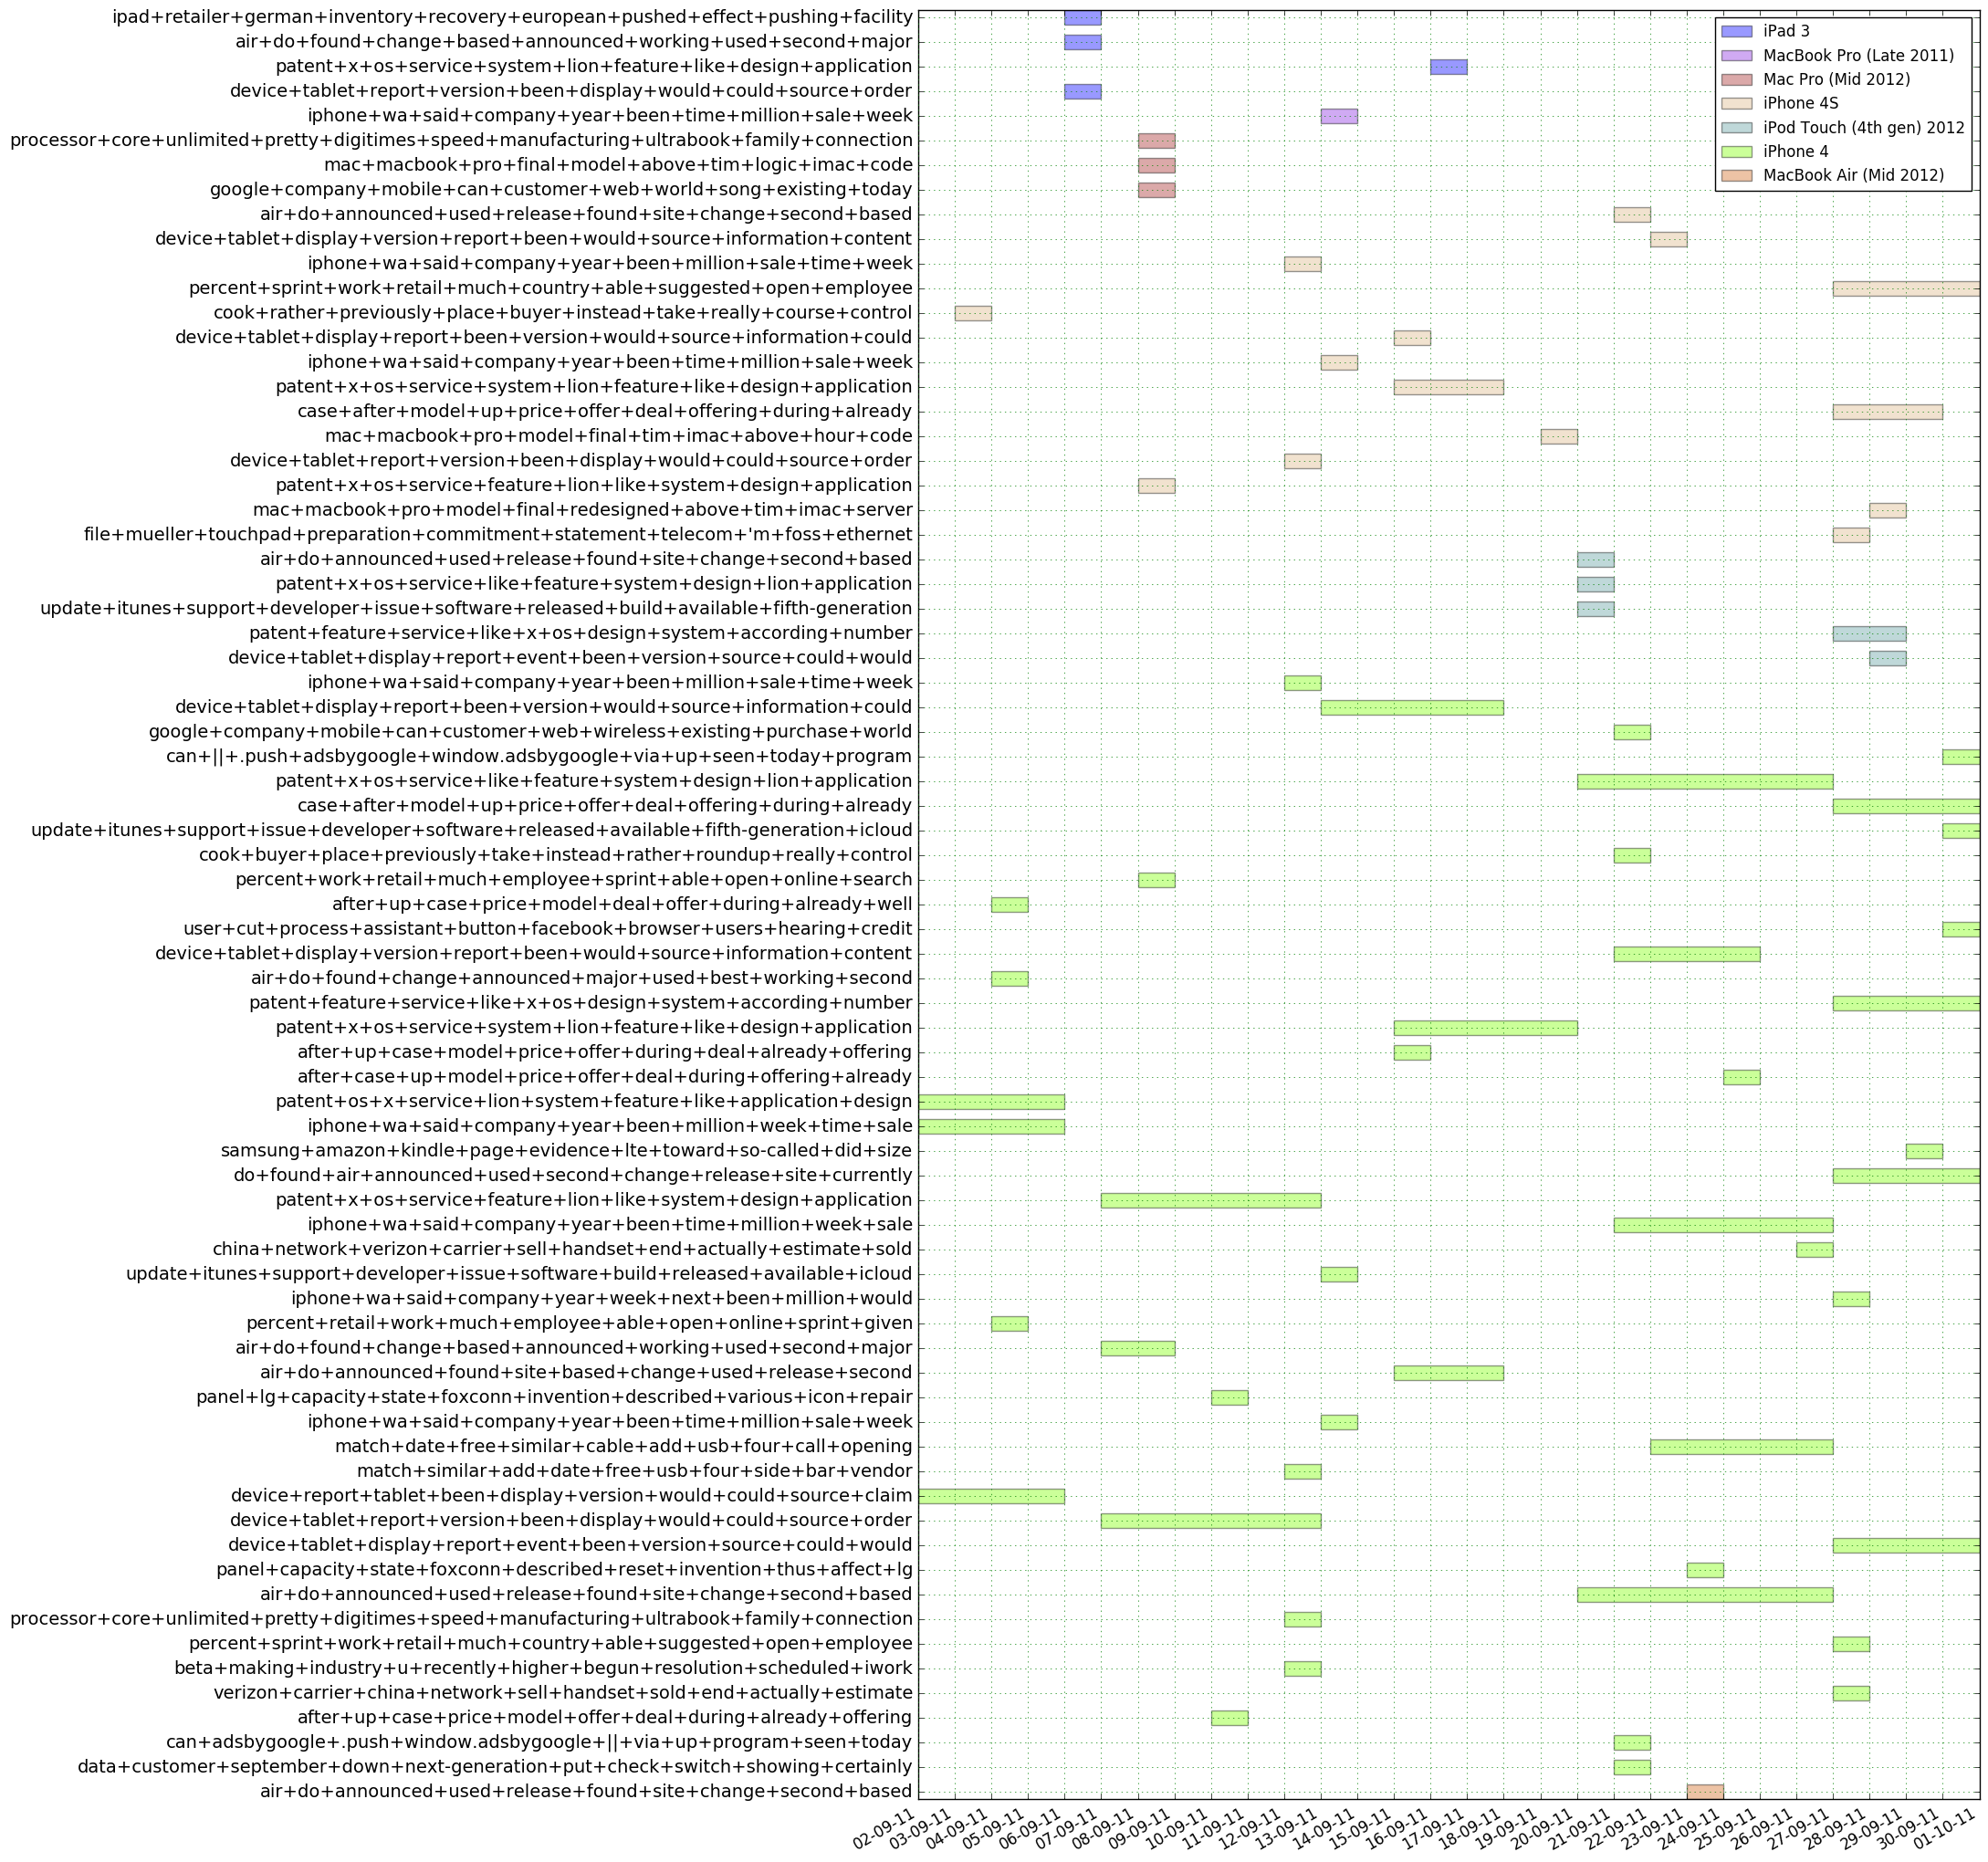

In [476]:
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from matplotlib.lines import Line2D
from itertools import product

def visualize_events(product_data):
    fig = plt.figure(figsize=(15, 28))
    ax = fig.add_subplot(111)
    pos = []
    leg_colors = []
    legend = []
    topics = []
    id = 1
    for i, product in enumerate(product_data):
#         legend.append(product)
        if product_data[product]:
            for topic, event in product_data[product]['events'].items():
                leg = None
                if product not in legend:
                    leg = product
                    legend.append(product)
                    
                ax.barh(bottom=(id*0.5)+1.0, 
                        width=(event.end_date - event.start_date).days + 1, 
                        left=event.start_date, height=0.3, 
                        align='center', 
                        color=colors[i].lower(), 
                        alpha = 0.4, 
                        label = leg)
                
                pos.append((id*0.5)+1.0)
                topics.append(topic)
                id+=1
                
    locsy, labelsy = plt.yticks(pos, topics)
    plt.setp(labelsy, fontsize = 14)

    # Format the x-axis

    ax.axis('tight')
    ax.grid(color = 'g', linestyle = ':')

    ax.xaxis_date() #Tell matplotlib that these are dates...

    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter("%d-%m-%y")

    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    
    labelsx = ax.get_xticklabels()
    plt.setp(labelsx, rotation=30, fontsize=12)

    # Format the legend
                
    ax.invert_yaxis()
    ax.legend(loc='upper right',  prop={'size':12})
    fig.autofmt_xdate()
    plt.show()

visualize_events(data)